# Fine-tuning InceptionV3 for food nutrition classifier

In [1]:
import tensorflow as tf
#suppress "INFO:tensorflow:Summary name .... is illegal; using ... instead." warnings.
tf.logging.set_verbosity(tf.logging.WARN)

from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dropout
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras.callbacks import TensorBoard
from download import download_file
import os.path
import numpy as np

Using TensorFlow backend.


### Database parameters

In [2]:
# Set metadata database paths
download_file('https://s3-eu-west-1.amazonaws.com/redbase/data.sqlite', 'data.sqlite')
database_path = 'data.sqlite'

# Set image database paths
download_file('https://s3-eu-west-1.amazonaws.com/redbase/image_data_299.sqlite', 'image_data_299.sqlite')
image_data_database_path = 'image_data_299.sqlite'

# Index cache
condition_indeces = None

#Set the id of classification stored in the database which will be used to train model.
classification_id = 11

File already downloaded (size: 174744576)
File already downloaded (size: 7500314624)


### Training parameters

In [3]:
# Limit number of images per class used for training and validating.
train_max = 750
val_max = 750
test_max = 750

# Image dimensions (Inception input size)
img_width, img_height = 299, 299

# Set batch size to biggest that fits in your memory.
batch_size = 256

# Number of epochs to train top inception network blocks.
top_epochs = 50

# Number of epochs to fine tune the network.
fit_epochs = 50

### Name the run

In [4]:
# Name the current parameters set. This name will be used as a Tensorboard log directory subfolder.
# having separate subfolder for each run will allow you to conviniently view performance changes beween runs.

run_name = "cid%d_tm%d_vm%d_bs%d_te%d_te%d" % (classification_id, 
                                               train_max, val_max, 
                                               batch_size, top_epochs, 
                                               fit_epochs)

print ("Run name: %s" % run_name)

Run name: cid11_tm750_vm750_bs256_te50_te50


### Initializing 

In [5]:
# Import custom SQLite data reader
from sqlite_data_loader import SQLiteDataLoader

sdl = SQLiteDataLoader(database_path, image_data_database_path)

# Load the number of nutrition classes
class_count = len(sdl.get_classes(classification_id))

print ("Number of nutrition classes: %d" % class_count)

Number of nutrition classes: 25


In [6]:
# Get the number of train and validation samples
nb_train_samples = 0
train_pr = 0.7
nb_validation_samples = 0
valid_pr = 0.3
nb_test_samples = 0
test_pr = 0.00

for ci in sdl.get_classes(classification_id):
    nb_train_samples += sdl.get_image_count_by_class(ci, classification_id, train_pr, train_max)
    nb_validation_samples += sdl.get_image_count_by_class(ci, classification_id, valid_pr, val_max)
    nb_test_samples += sdl.get_image_count_by_class(ci, classification_id, test_pr, test_max)

print ("Train samples: %d" % nb_train_samples)
print ("Validation samples: %d" % nb_validation_samples)
print ("Test samples: %d" % nb_test_samples)

Class 0 has 58266 images.
Class 1 has 36703 images.
Class 2 has 34386 images.
Class 3 has 92852 images.
Class 4 has 7091 images.
Class 5 has 14208 images.
Class 6 has 1866 images.
Class 7 has 2988 images.
Class 8 has 1336 images.
Class 9 has 14319 images.
Class 10 has 9046 images.
Class 11 has 23630 images.
Class 12 has 34143 images.
Class 13 has 8237 images.
Class 14 has 13262 images.
Class 15 has 4064 images.
Class 16 has 4952 images.
Class 17 has 3401 images.
Class 18 has 8412 images.
Class 19 has 13109 images.
Class 20 has 9839 images.
Class 21 has 2063 images.
Class 22 has 1165 images.
Class 23 has 6086 images.
Class 24 has 534 images.
Train samples: 12973
Validation samples: 5560
Test samples: 0


## Visualize recipe classification

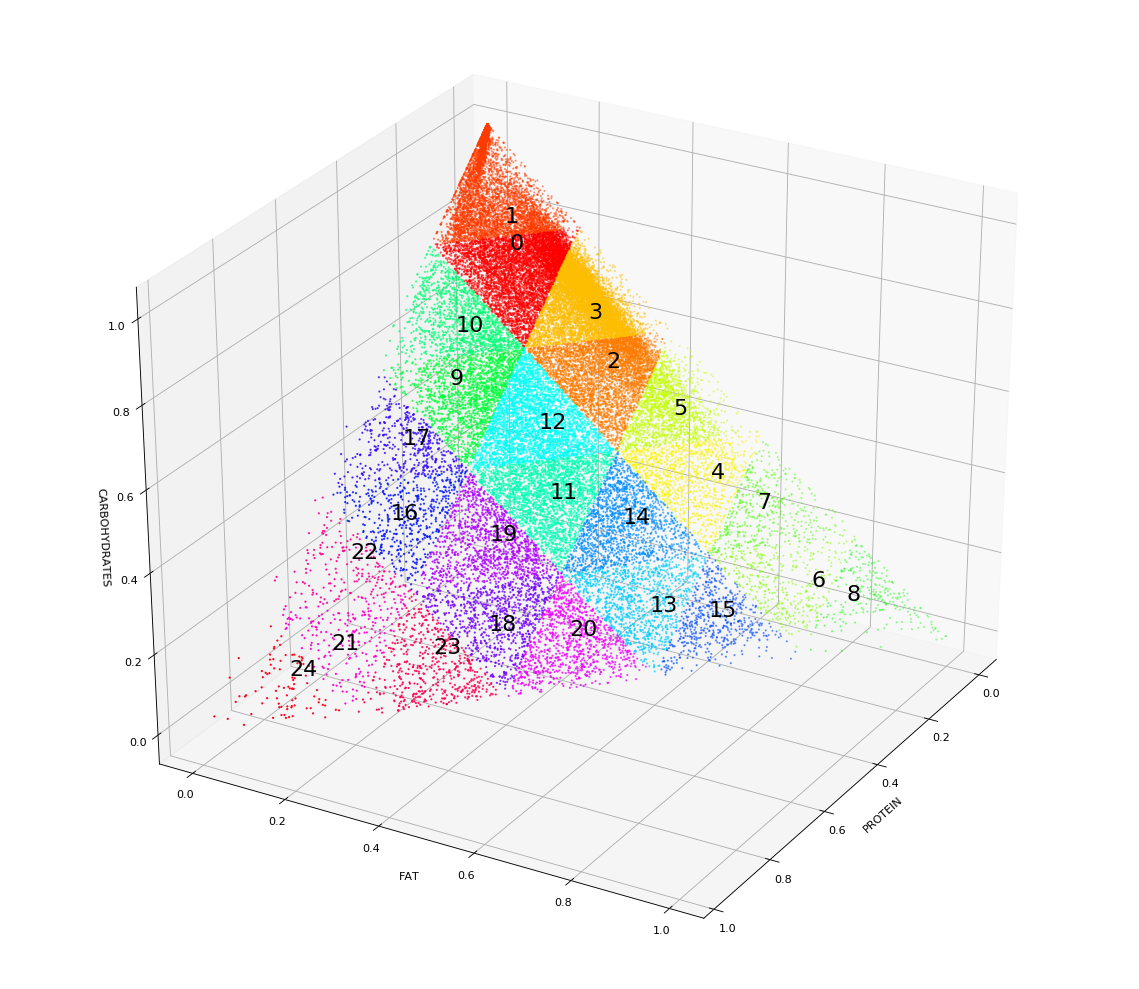

In [7]:
from mpl_toolkits import mplot3d

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')

ax = plt.axes(projection='3d')

ax.view_init(30, 30)

rates = np.array(sdl.get_nutrition_values(classification_id))

# Data for three-dimensional scattered points
rates_x = rates[:,0]
rates_y = rates[:,1]
rates_z = rates[:,2]

rates_c = rates[:,3]
rates_c /= class_count

ax.scatter3D(rates_x, rates_y, rates_z, c=rates_c, cmap='hsv', s=1);

ax.set_xlabel('PROTEIN')
ax.set_ylabel('FAT')
ax.set_zlabel('CARBOHYDRATES')

centroids = np.array(sdl.get_centroids(classification_id)) 

for cd in centroids:
    ax.text(cd[0],cd[1],cd[2],  '%d' % cd[3], size=20, zorder=1, color='k') 

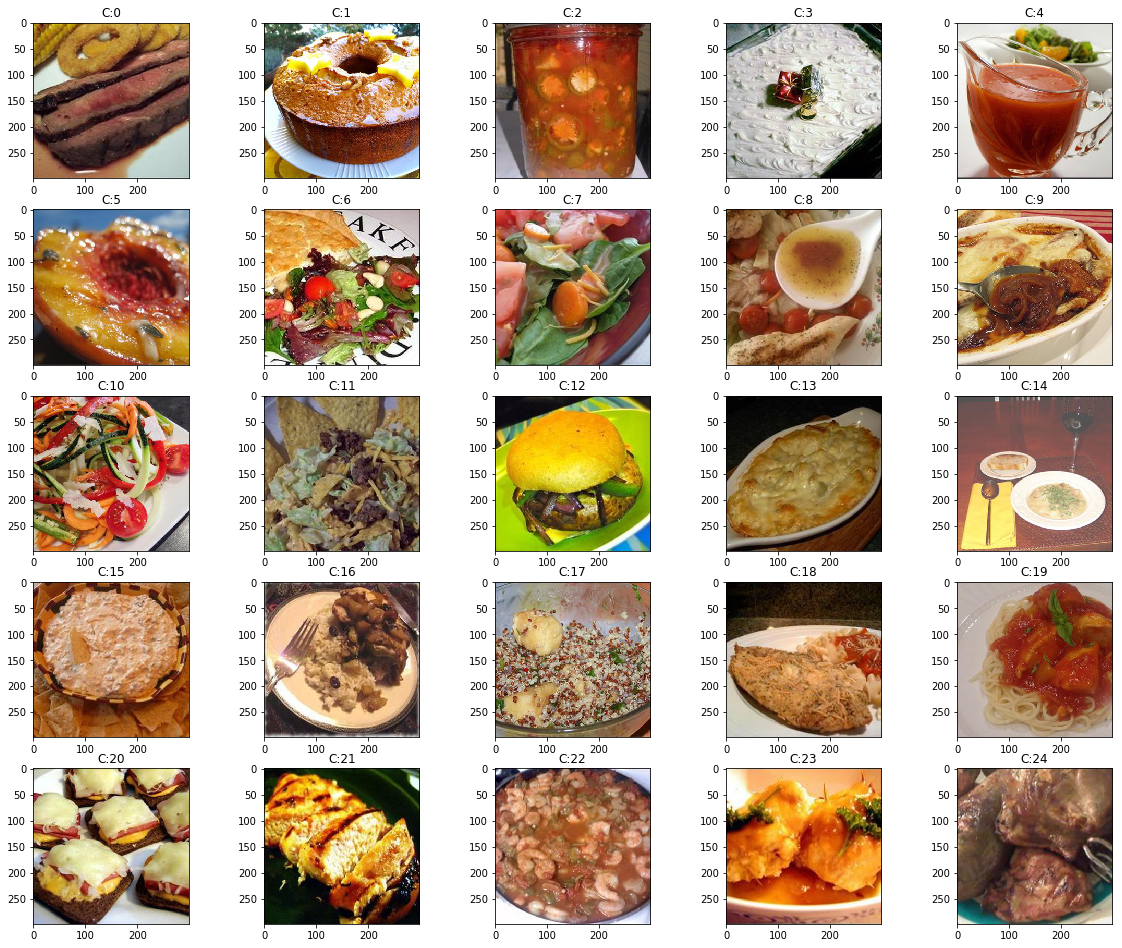

In [8]:
"""
Show an image for each nutrition class. 
"""

from image_ex import load_img_bytes
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20,20))
columns = 5

for ci in range(class_count):
    image_id = sdl.get_image_ids_by_class(ci, classification_id, 0, 1)[0]
    image_data = sdl.get_image_data_by_id(image_id)
    pil_img = load_img_bytes(image_data)
    
    sp = fig.add_subplot(class_count / columns + 1, columns, ci + 1)
    sp.set_title('C:%d'%ci)
    plt.imshow(pil_img)
    

## Building the model

In [9]:
# Set checkpoint save files
top_layers_checkpoint_path = 'cp.top.%s.hdf5' % run_name
fine_tuned_checkpoint_path = 'cp.ftuned.%s.hdf5' % run_name
new_extended_inception_weights = 'weights.%s.hdf5' % run_name

print ("Top layer train checkpoint: %s" % top_layers_checkpoint_path)
print ("Fine tune checkpoint: %s" % fine_tuned_checkpoint_path)
print ("Final weights: %s" % new_extended_inception_weights)

Top layer train checkpoint: cp.top.cid11_tm750_vm750_bs256_te50_te50.hdf5
Fine tune checkpoint: cp.ftuned.cid11_tm750_vm750_bs256_te50_te50.hdf5
Final weights: weights.cid11_tm750_vm750_bs256_te50_te50.hdf5


In [10]:
# create the base pre-trained model
base_model = InceptionV3(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer    # ADDED BY ME
x = Dense(1024, activation='relu')(x)  # ADDED BY ME
# let's add a dropout regularization   # ADDED BY ME
x = Dropout(0.4)(x)                    # ADDED BY ME
# let's add a second fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- we have 125 classes
predictions = Dense(class_count, activation='softmax')(x)

# this is the model we will train
model = Model(input=base_model.input, output=predictions)

if os.path.exists(top_layers_checkpoint_path):
    model.load_weights(top_layers_checkpoint_path)
    print ("Checkpoint '" + top_layers_checkpoint_path + "' loaded.")

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'], )

/home/aleksas/anaconda3/envs/recipes/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Checkpoint 'cp.top.cid11_tm750_vm750_bs256_te50_te50.hdf5' loaded.


### Setup data generators

In [11]:
# Import custom image data generator capable of taking lamda function to load data from SQLite 
from image_ex import ImageDataGeneratorEx

# prepare data augmentation configuration
train_datagen = ImageDataGeneratorEx(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGeneratorEx(rescale=1. / 255)

get_class_array      = lambda: sdl.get_classes(classification_id)
get_image_data_by_id = lambda image_id: sdl.get_image_data_by_id(image_id)

get_train_image_count_by_class = lambda ci: sdl.get_image_count_by_class(ci, classification_id, train_pr, train_max)
get_valid_image_count_by_class = lambda ci: sdl.get_image_count_by_class(ci, classification_id, valid_pr, val_max)

get_train_image_ids_by_class = lambda ci: sdl.get_image_ids_by_class(ci, classification_id, 0, get_train_image_count_by_class(ci))
get_valid_image_ids_by_class = lambda ci: sdl.get_image_ids_by_class(ci, classification_id, get_train_image_count_by_class(ci), get_valid_image_count_by_class(ci))

train_generator = train_datagen.flow_from_database(
    get_class_array=get_class_array,
    get_image_count_by_class=get_train_image_count_by_class,
    get_image_ids_by_class=get_train_image_ids_by_class,
    get_image_data_by_id=get_image_data_by_id,
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_database(
    get_class_array=get_class_array,
    get_image_count_by_class=get_valid_image_count_by_class,
    get_image_ids_by_class=get_valid_image_ids_by_class,
    get_image_data_by_id=get_image_data_by_id,
    batch_size=batch_size,
    class_mode='categorical')

Found 12973 images belonging to 25 classes.
Found 5560 images belonging to 25 classes.


In [12]:
#Save the model after every epoch.
mc_top = ModelCheckpoint(top_layers_checkpoint_path, monitor='val_acc', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=1)

#Save the TensorBoard logs.
tb = TensorBoard(log_dir=('./logs/%s'%run_name), histogram_freq=1, write_graph=True, write_images=True)

In [ ]:
# train the model on the new data for a few epochs
model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=top_epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size,
    callbacks=[mc_top, tb])

At this point, the top layers are well trained and we can start fine-tuning convolutional layers from inception V3. We will freeze the bottom N layers and train the remaining top layers.

In [13]:
# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)

0 input_1
1 conv2d_1
2 batch_normalization_1
3 activation_1
4 conv2d_2
5 batch_normalization_2
6 activation_2
7 conv2d_3
8 batch_normalization_3
9 activation_3
10 max_pooling2d_1
11 conv2d_4
12 batch_normalization_4
13 activation_4
14 conv2d_5
15 batch_normalization_5
16 activation_5
17 max_pooling2d_2
18 conv2d_9
19 batch_normalization_9
20 activation_9
21 conv2d_7
22 conv2d_10
23 batch_normalization_7
24 batch_normalization_10
25 activation_7
26 activation_10
27 average_pooling2d_1
28 conv2d_6
29 conv2d_8
30 conv2d_11
31 conv2d_12
32 batch_normalization_6
33 batch_normalization_8
34 batch_normalization_11
35 batch_normalization_12
36 activation_6
37 activation_8
38 activation_11
39 activation_12
40 mixed0
41 conv2d_16
42 batch_normalization_16
43 activation_16
44 conv2d_14
45 conv2d_17
46 batch_normalization_14
47 batch_normalization_17
48 activation_14
49 activation_17
50 average_pooling2d_2
51 conv2d_13
52 conv2d_15
53 conv2d_18
54 conv2d_19
55 batch_normalization_13
56 batch_norma

In [14]:
# Save the model after every epoch.
mc_fit = ModelCheckpoint(fine_tuned_checkpoint_path, monitor='val_acc', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=1)

# Load saved wights
if os.path.exists(fine_tuned_checkpoint_path):
    model.load_weights(fine_tuned_checkpoint_path)
    print ("Checkpoint '" + fine_tuned_checkpoint_path + "' loaded.")


Checkpoint 'cp.ftuned.cid11_tm750_vm750_bs256_te50_te50.hdf5' loaded.


In [15]:
# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 172 layers and unfreeze the rest:
for layer in model.layers[:172]:
   layer.trainable = False
for layer in model.layers[172:]:
   layer.trainable = True

In [16]:
# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
from keras.optimizers import SGD
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
#model.fit_generator(...)

In [ ]:
model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=fit_epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size,
    callbacks=[mc_fit, tb])

model.save_weights(new_extended_inception_weights)

In [20]:
model.load_weights(new_extended_inception_weights)

from keras.preprocessing import image as kpi

image_id = 704578

img = load_img_bytes(sdl.get_image_data_by_id(image_id))
img_tensor = kpi.img_to_array(img).astype('float32')/255

total = 0
matched = 0
for ci in range(class_count):
    list_of_tensors = []
    
    for image_id in get_valid_image_ids_by_class(ci):
        im = load_img_bytes(sdl.get_image_data_by_id(image_id))
        im_data = kpi.img_to_array(im).astype('float32') / 255
        tensor = np.expand_dims(im_data, axis=0)        
        list_of_tensors.append(tensor)
    
    batch = np.vstack(list_of_tensors)    
    
    class_total = 0
    class_matched = 0
    for image_id, prediction in zip(image_ids, model.predict(batch)):
        class_total += 1
        if ci == np.argmax(prediction):
            class_matched += 1
    total += class_total
    matched += class_matched
    print ('class (%d) accuracy: %f' % (ci, class_matched/class_total))
    print ('total accuracy %f' % (matched/total))
        

class (0) accuracy: 0.120000
total accuracy 0.120000
class (1) accuracy: 0.822222
total accuracy 0.471111
class (2) accuracy: 0.191111
total accuracy 0.377778
class (3) accuracy: 0.573333
total accuracy 0.426667
class (4) accuracy: 0.057778
total accuracy 0.352889
class (5) accuracy: 0.022222
total accuracy 0.297778
class (6) accuracy: 0.422222
total accuracy 0.315556
class (7) accuracy: 0.048889
total accuracy 0.282222
class (8) accuracy: 0.182222
total accuracy 0.271111
class (9) accuracy: 0.026667
total accuracy 0.246667
class (10) accuracy: 0.048889
total accuracy 0.228687
class (11) accuracy: 0.053333
total accuracy 0.214074
class (12) accuracy: 0.115556
total accuracy 0.206496
class (13) accuracy: 0.022222
total accuracy 0.193333
class (14) accuracy: 0.080000
total accuracy 0.185778
class (15) accuracy: 0.408889
total accuracy 0.199722
class (16) accuracy: 0.017778
total accuracy 0.189020
class (17) accuracy: 0.164444
total accuracy 0.187654
class (18) accuracy: 0.075556
total ac